# Automated CapsnetsS2I train + test

First, import stuff

In [22]:
import model_s2i
import data_loader
import tensorflow as tf

In [23]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [34]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'media-class'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
###################################################################
#         '../data-capsnets/diacritics/scenario0/train.txt',
#         '../data-capsnets/diacritics/scenario1/train.txt',
#         '../data-capsnets/diacritics/scenario2/train.txt',
#         '../data-capsnets/diacritics/scenario31/train.txt',
#         '../data-capsnets/diacritics/scenario32/train.txt',
#         '../data-capsnets/diacritics/scenario33/train.txt',
###################################################################
        '../data-capsnets/diacritics/scenario0/train-media.txt',
        '../data-capsnets/diacritics/scenario1/train-media.txt',
        '../data-capsnets/diacritics/scenario2/train-media.txt',
        '../data-capsnets/diacritics/scenario31/train-media.txt',
        '../data-capsnets/diacritics/scenario32/train-media.txt',
        '../data-capsnets/diacritics/scenario33/train-media.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
###################################################################
#     '../data-capsnets/diacritics/scenario0/test.txt',
#     '../data-capsnets/diacritics/scenario1/test.txt',
#     '../data-capsnets/diacritics/scenario2/test.txt',
#     '../data-capsnets/diacritics/scenario31/test.txt',
#     '../data-capsnets/diacritics/scenario32/test.txt',
#     '../data-capsnets/diacritics/scenario33/test.txt',
###################################################################
    '../data-capsnets/diacritics/scenario0/test-media.txt',
    '../data-capsnets/diacritics/scenario1/test-media.txt',
    '../data-capsnets/diacritics/scenario2/test-media.txt',
    '../data-capsnets/diacritics/scenario31/test-media.txt',
    '../data-capsnets/diacritics/scenario32/test-media.txt',
    '../data-capsnets/diacritics/scenario33/test-media.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [35]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.08
------------------load word2vec end---------------------


# Flag setting functions + utils

In [37]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 64

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 16, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 20, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 3, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [36]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 0-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.142857
F score 0.142857
Slot filling
F1 score: 0.036288
Accuracy: 0.230736
------------------epoch :  0  Loss:  19.145634 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.647619
F score 0.647619
Slot filling
F1 score: 0.345946
Accuracy: 0.947619
Current F score mean 0.4967824967824968
Best F score mean 0.4967824967824968
------------------epoch :  1  Loss:  1.8918059 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.938095
F score 0.938095
Slot filling
F1 sco

------------------epoch :  5  Loss:  0.015851606 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.996337
Accuracy: 0.999567
Current F score mean 0.9957875457875458
Best F score mean 0.9957875457875458
------------------epoch :  6  Loss:  0.012960608 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.996337
Accuracy: 0.999567
Current F score mean 0.9957875457875458
Best F score mean 0.9957875457875458
------------------epoch :  7  Loss:  0.010900062 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.995238
F score 0.995238
Slot filling
F1 score: 0.996337
Accuracy: 0.999567
Current F score mean 0.9957875457875458
Best F score mean 0.9957875457875458
------------------epoch :  8  Loss:  0.0093472535 ----------------------
           V

------------------epoch :  11  Loss:  0.0028003748 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.977444
Accuracy: 0.997403
Current F score mean 0.9887218045112782
Best F score mean 0.9957875457875458
------------------epoch :  12  Loss:  0.0024874504 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.977444
Accuracy: 0.997403
Current F score mean 0.9887218045112782
Best F score mean 0.9957875457875458
------------------epoch :  13  Loss:  0.0022429398 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.977444
Accuracy: 0.997403
Current F score mean 0.9887218045112782
Best F score mean 0.9957875457875458
------------------epoch :  14  Loss:  0.0020485257 ----------------------
     

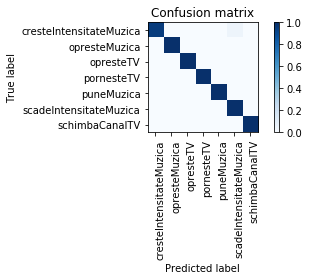

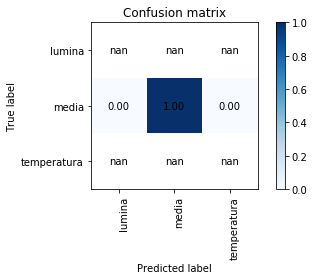

Intent F1: 0.992857
Slot F1: 0.983516
------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 1-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.047059
F score 0.047059
Slot filling
F1 score: 0.013245
Accuracy: 0.299465
------------------epoch :  0  Loss:  19.160175 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.835294
F score 0.835294
Slot filling
F1 score: 0.448780
Accuracy: 0.940642
Current F score mean 0.6420373027259685
Best F score mean 0.6420373027259685
------------------epoch :  1  Loss:  2.477189 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.982353

------------------epoch :  5  Loss:  0.015145447 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996441
Accuracy: 0.999465
Current F score mean 0.998220640569395
Best F score mean 1.0
------------------epoch :  6  Loss:  0.012250226 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996441
Accuracy: 0.999465
Current F score mean 0.998220640569395
Best F score mean 1.0
------------------epoch :  7  Loss:  0.01065355 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996441
Accuracy: 0.999465
Current F score mean 0.998220640569395
Best F score mean 1.0
------------------epoch :  8  Loss:  0.009581326 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection

------------------epoch :  13  Loss:  0.006596064 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  14  Loss:  0.006223887 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  15  Loss:  0.0059047146 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  16  Loss:  0.005632272 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.

<Figure size 432x288 with 0 Axes>

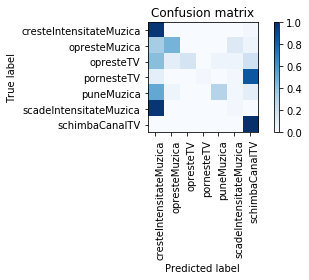

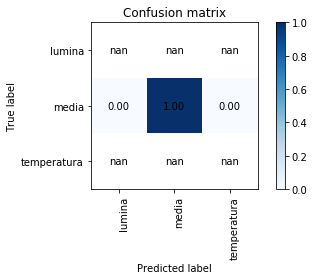

Intent F1: 0.425000
Slot F1: 0.679144
------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 2-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.246667
F score 0.246667
Slot filling
F1 score: 0.049720
Accuracy: 0.113333
------------------epoch :  0  Loss:  15.497585 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.913333
F score 0.913333
Slot filling
F1 score: 0.165605
Accuracy: 0.920606
Current F score mean 0.5394692144373673
Best F score mean 0.5394692144373673
------------------epoch :  1  Loss:  2.9830854 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.93333

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980000
F score 0.980000
Slot filling
F1 score: 0.996337
Accuracy: 0.999394
Current F score mean 0.9881684981684982
Best F score mean 0.9982078853046594
------------------epoch :  5  Loss:  0.009706811 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980000
F score 0.980000
Slot filling
F1 score: 0.996337
Accuracy: 0.999394
Current F score mean 0.9881684981684982
Best F score mean 0.9982078853046594
------------------epoch :  6  Loss:  0.008786641 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980000
F score 0.980000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 0.99
Best F score mean 0.9982078853046594
------------------epoch :  7  Loss:  0.0069426578 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980000
F score 0.

------------------epoch :  12  Loss:  0.005638663 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  13  Loss:  0.005299406 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  14  Loss:  0.005006742 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  15  Loss:  0.0047522187 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.

<Figure size 432x288 with 0 Axes>

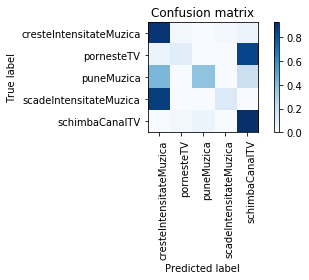

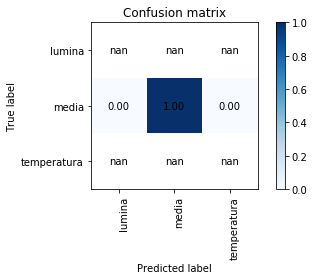

Intent F1: 0.485000
Slot F1: 0.658730
------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 31-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.176471
F score 0.176471
Slot filling
F1 score: 0.062350
Accuracy: 0.203743
------------------epoch :  0  Loss:  21.552273 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.923529
F score 0.923529
Slot filling
F1 score: 0.388571
Accuracy: 0.942781
Current F score mean 0.6560504201680672
Best F score mean 0.6560504201680672
------------------epoch :  1  Loss:  2.2871814 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9470

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  5  Loss:  0.0131417345 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  6  Loss:  0.011144229 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  7  Loss:  0.009930189 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score me

------------------epoch :  13  Loss:  0.0063371398 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994048
F score 0.994048
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 0.9970238095238095
Best F score mean 1.0
------------------epoch :  14  Loss:  0.006134576 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994048
F score 0.994048
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 0.9970238095238095
Best F score mean 1.0
------------------epoch :  15  Loss:  0.0059582638 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.994048
F score 0.994048
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 0.9970238095238095
Best F score mean 1.0
------------------epoch :  16  Loss:  0.0058036633 ----------------------
           VALIDATION SET PERFORMANCE        
Inten

<Figure size 432x288 with 0 Axes>

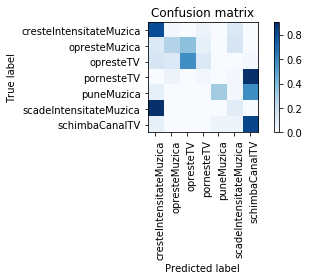

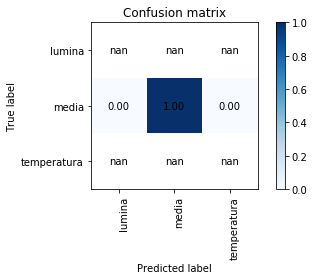

Intent F1: 0.417857
Slot F1: 0.514286
------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 32-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.176471
F score 0.176471
Slot filling
F1 score: 0.014599
Accuracy: 0.446524
------------------epoch :  0  Loss:  20.260239 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.635294
F score 0.635294
Slot filling
F1 score: 0.346369
Accuracy: 0.937433
Current F score mean 0.4908314163654288
Best F score mean 0.4908314163654288
------------------epoch :  1  Loss:  3.9380107 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.9588

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  7  Loss:  0.010967042 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  8  Loss:  0.009845845 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mean 1.0
Best F score mean 1.0
------------------epoch :  9  Loss:  0.009003574 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 1.000000
Accuracy: 1.000000
Current F score mea

------------------epoch :  15  Loss:  0.0068672514 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996364
Accuracy: 0.999459
Current F score mean 0.9981818181818182
Best F score mean 1.0
------------------epoch :  16  Loss:  0.006621369 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996364
Accuracy: 0.999459
Current F score mean 0.9981818181818182
Best F score mean 1.0
------------------epoch :  17  Loss:  0.0064026006 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.996364
Accuracy: 0.999459
Current F score mean 0.9981818181818182
Best F score mean 1.0
------------------epoch :  18  Loss:  0.0062059634 ----------------------
           VALIDATION SET PERFORMANCE        
Inten

<Figure size 432x288 with 0 Axes>

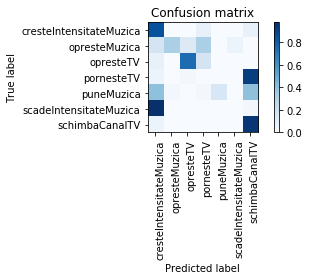

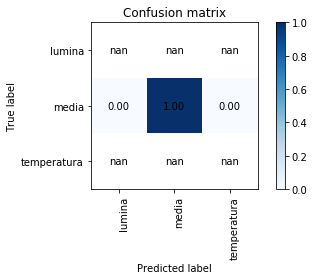

Intent F1: 0.432143
Slot F1: 0.688889
------------------read datasets begin-------------------
max length is 11
max length is 11
------------------read datasets end---------------------
TRAINING 33-media-class
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.176471
F score 0.176471
Slot filling
F1 score: 0.046512
Accuracy: 0.358289
------------------epoch :  0  Loss:  72.59282 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.294118
F score 0.294118
Slot filling
F1 score: 0.000000
Accuracy: 0.935829
Current F score mean 0.14705882352941177
Best F score mean 0.14705882352941177
------------------epoch :  1  Loss:  32.71602 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.3529

------------------epoch :  5  Loss:  2.4179559 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.470588
F score 0.470588
Slot filling
F1 score: 0.296296
Accuracy: 0.903743
Current F score mean 0.383442265795207
Best F score mean 0.6470588235294117
------------------epoch :  6  Loss:  1.3086193 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.647059
F score 0.647059
Slot filling
F1 score: 0.066667
Accuracy: 0.860963
Current F score mean 0.3568627450980392
Best F score mean 0.6470588235294117
------------------epoch :  7  Loss:  0.58486754 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.705882
F score 0.705882
Slot filling
F1 score: 0.210526
Accuracy: 0.919786
Current F score mean 0.4582043343653251
Best F score mean 0.6470588235294117
------------------epoch :  8  Loss:  0.36146593 ----------------------
           VALIDATIO

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.823529
F score 0.823529
Slot filling
F1 score: 0.600000
Accuracy: 0.957219
Current F score mean 0.7117647058823529
Best F score mean 0.7394957983193278
------------------epoch :  12  Loss:  0.101265125 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.823529
F score 0.823529
Slot filling
F1 score: 0.526316
Accuracy: 0.951872
Current F score mean 0.6749226006191951
Best F score mean 0.7394957983193278
------------------epoch :  13  Loss:  0.063239664 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.823529
F score 0.823529
Slot filling
F1 score: 0.600000
Accuracy: 0.957219
Current F score mean 0.7117647058823529
Best F score mean 0.7394957983193278
------------------epoch :  14  Loss:  0.028855255 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.8

<Figure size 432x288 with 0 Axes>

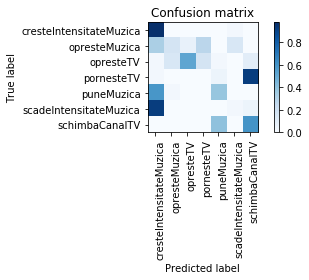

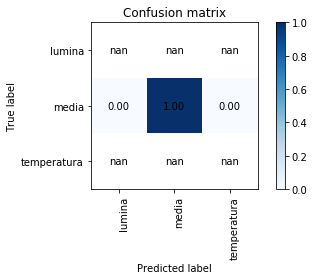

Intent F1: 0.383513
Slot F1: 0.356164


<Figure size 432x288 with 0 Axes>

In [38]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)